# Z repo

https://github.com/KevinLiao159/MyDataSciencePortfolio/tree/master/movie_recommender


# Overview

In this project, I will build an item-based collaborative filtering system using [MovieLens Datasets](https://grouplens.org/datasets/movielens/latest/). Specically, I will train a KNN models to cluster similar movies based on user's ratings and make movie recommendation based on similarity score of previous rated movies. 


## [Recommender system](https://en.wikipedia.org/wiki/Recommender_system)
A recommendation system is basically an information filtering system that seeks to predict the "rating" or "preference" a user would give to an item. It is widely used in different internet / online business such as Amazon, Netflix, Spotify, or social media like Facebook and Youtube. By using recommender systems, those companies are able to provide better or more suited products/services/contents that are personalized to a user based on his/her historical consumer behaviors

Recommender systems typically produce a list of recommendations through collaborative filtering or through content-based filtering

This project will focus on collaborative filtering and use item-based collaborative filtering systems make movie recommendation


## [Item-based Collaborative Filtering](https://beckernick.github.io/music_recommender/)
Collaborative filtering based systems use the actions of users to recommend other items. In general, they can either be user based or item based. User based collaborating filtering uses the patterns of users similar to me to recommend a product (users like me also looked at these other items). Item based collaborative filtering uses the patterns of users who browsed the same item as me to recommend me a product (users who looked at my item also looked at these other items). Item-based approach is usually prefered than user-based approach. User-based approach is often harder to scale because of the dynamic nature of users, whereas items usually don't change much, so item-based approach often can be computed offline.


## Data Sets
I use [MovieLens Datasets](https://grouplens.org/datasets/movielens/latest/).
This dataset (ml-latest.zip) describes 5-star rating and free-text tagging activity from [MovieLens](http://movielens.org), a movie recommendation service. It contains 27753444 ratings and 1108997 tag applications across 58098 movies. These data were created by 283228 users between January 09, 1995 and September 26, 2018. This dataset was generated on September 26, 2018.

Users were selected at random for inclusion. All selected users had rated at least 1 movies. No demographic information is included. Each user is represented by an id, and no other information is provided.

The data are contained in the files `genome-scores.csv`, `genome-tags.csv`, `links.csv`, `movies.csv`, `ratings.csv` and `tags.csv`.

## Project Content
1. Load data
2. Exploratory data analysis
3. Train KNN model for item-based collaborative filtering
4. Use this trained model to make movie recommendations to myself
5. Deep dive into the bottleneck of item-based collaborative filtering.
 - cold start problem
 - data sparsity problem
 - popular bias (how to recommend products from the tail of product distribution)
 - scalability bottleneck
6. Further study

In [7]:
import os
import time

# data science imports
import math
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

# utils import
from fuzzywuzzy import fuzz

# visualization imports
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

%matplotlib inline

In [8]:
# path config
data_path = './data'
movies_filename = 'movie.csv'
ratings_filename = 'rating.csv'

## 1. Load Data

In [9]:
df_movies = pd.read_csv(
    os.path.join(data_path, movies_filename),
    usecols=['movieId', 'title'],
    dtype={'movieId': 'int32', 'title': 'str'})

df_ratings = pd.read_csv(
    os.path.join(data_path, ratings_filename),
    usecols=['userId', 'movieId', 'rating'],
    dtype={'userId': 'int32', 'movieId': 'int32', 'rating': 'float32'})

In [10]:
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27278 entries, 0 to 27277
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  27278 non-null  int32 
 1   title    27278 non-null  object
dtypes: int32(1), object(1)
memory usage: 319.8+ KB


In [11]:
df_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000263 entries, 0 to 20000262
Data columns (total 3 columns):
 #   Column   Dtype  
---  ------   -----  
 0   userId   int32  
 1   movieId  int32  
 2   rating   float32
dtypes: float32(1), int32(2)
memory usage: 228.9 MB


In [12]:
df_movies.head()

,movieId,title
0,1,Toy Story (1995)
1,2,Jumanji (1995)
2,3,Grumpier Old Men (1995)
3,4,Waiting to Exhale (1995)
4,5,Father of the Bride Part II (1995)


In [13]:
df_ratings.head()

,userId,movieId,rating
0,1,2,3.5
1,1,29,3.5
2,1,32,3.5
3,1,47,3.5
4,1,50,3.5


In [14]:
num_users = len(df_ratings.userId.unique())
num_items = len(df_ratings.movieId.unique())
print('There are {} unique users and {} unique movies in this data set'.format(num_users, num_items))

There are 138493 unique users and 26744 unique movies in this data set


## 2. Exploratory data analysis
 - Plot the counts of each rating
 - Plot rating frequency of each movie

#### 1. Plot the counts of each rating

we first need to get the counts of each rating from ratings data

In [15]:
# get count
df_ratings_cnt_tmp = pd.DataFrame(df_ratings.groupby('rating').size(), columns=['count'])
df_ratings_cnt_tmp

,count
rating,
0.5,239125
1.0,680732
1.5,279252
2.0,1430997
2.5,883398
3.0,4291193
3.5,2200156
4.0,5561926
4.5,1534824


We can see that above table does not include counts of zero rating score. So we need to add that in rating count dataframe as well

In [16]:
# there are a lot more counts in rating of zero
total_cnt = num_users * num_items
rating_zero_cnt = total_cnt - df_ratings.shape[0]
# append counts of zero rating to df_ratings_cnt
df_ratings_cnt = df_ratings_cnt_tmp.append(
    pd.DataFrame({'count': rating_zero_cnt}, index=[0.0]),
    verify_integrity=True,
).sort_index()
df_ratings_cnt

,count
0.0,3683856529
0.5,239125
1.0,680732
1.5,279252
2.0,1430997
2.5,883398
3.0,4291193
3.5,2200156
4.0,5561926
4.5,1534824


The count for zero rating score is too big to compare with others. So let's take log transform for count values and then we can plot them to compare

In [17]:
# add log count
df_ratings_cnt['log_count'] = np.log(df_ratings_cnt['count'])
df_ratings_cnt

,count,log_count
0.0,3683856529,22.027226
0.5,239125,12.384742
1.0,680732,13.430924
1.5,279252,12.539870
2.0,1430997,14.173882
2.5,883398,13.691531
3.0,4291193,15.272075
3.5,2200156,14.604039
4.0,5561926,15.531455
4.5,1534824,14.243926


Text(0, 0.5, 'number of ratings')

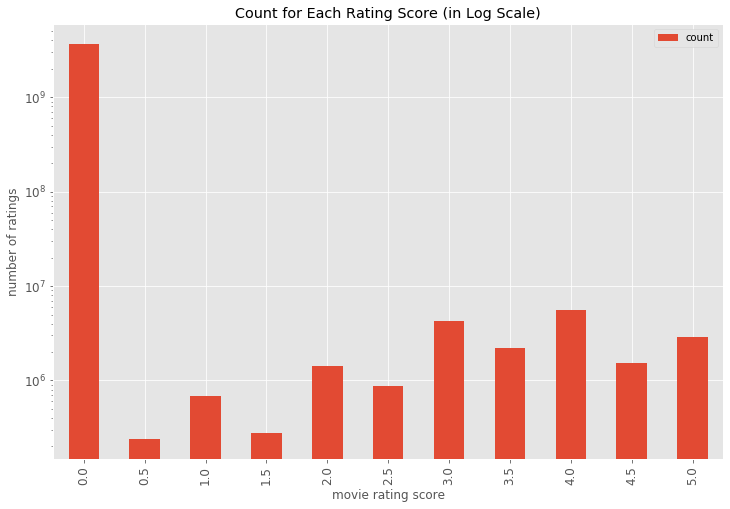

In [18]:
ax = df_ratings_cnt[['count']].reset_index().rename(columns={'index': 'rating score'}).plot(
    x='rating score',
    y='count',
    kind='bar',
    figsize=(12, 8),
    title='Count for Each Rating Score (in Log Scale)',
    logy=True,
    fontsize=12,
)
ax.set_xlabel("movie rating score")
ax.set_ylabel("number of ratings")

It's interesting that there are more people giving rating score of 3 and 4 than other scores 

#### 2. Plot rating frequency of all movies

In [19]:
df_ratings.head()

,userId,movieId,rating
0,1,2,3.5
1,1,29,3.5
2,1,32,3.5
3,1,47,3.5
4,1,50,3.5


In [20]:
# get rating frequency
df_movies_cnt = pd.DataFrame(df_ratings.groupby('movieId').size(), columns=['count'])
df_movies_cnt.head()

,count
movieId,
1,49695
2,22243
3,12735
4,2756
5,12161


Text(0, 0.5, 'number of ratings')

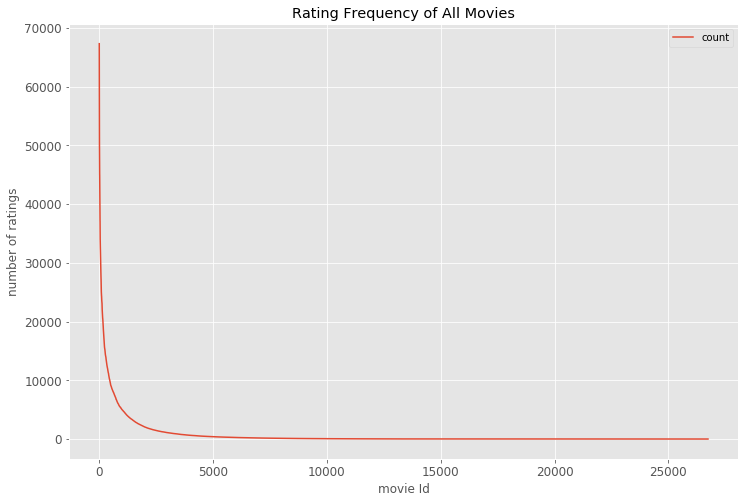

In [21]:
# plot rating frequency of all movies
ax = df_movies_cnt \
    .sort_values('count', ascending=False) \
    .reset_index(drop=True) \
    .plot(
        figsize=(12, 8),
        title='Rating Frequency of All Movies',
        fontsize=12
    )
ax.set_xlabel("movie Id")
ax.set_ylabel("number of ratings")

The distribution of ratings among movies often satisfies a property in real-world settings,
which is referred to as the long-tail property. According to this property, only a small
fraction of the items are rated frequently. Such items are referred to as popular items. The
vast majority of items are rated rarely. This results in a highly skewed distribution of the
underlying ratings.

Let's plot the same distribution but with log scale

Text(0, 0.5, 'number of ratings (log scale)')

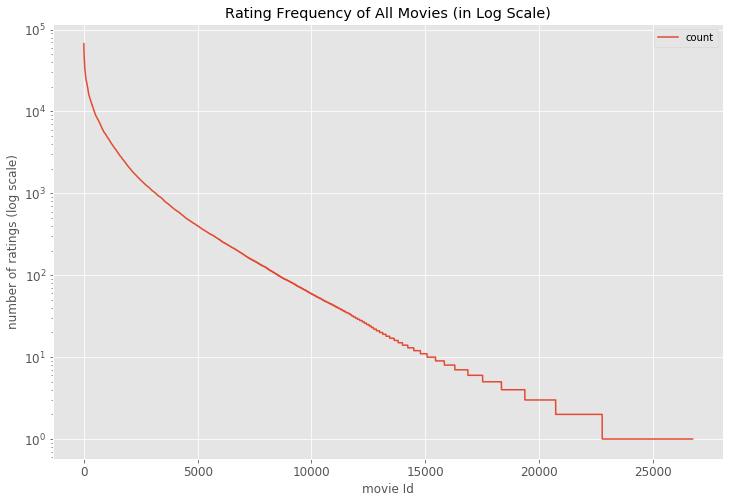

In [22]:
# plot rating frequency of all movies in log scale
ax = df_movies_cnt \
    .sort_values('count', ascending=False) \
    .reset_index(drop=True) \
    .plot(
        figsize=(12, 8),
        title='Rating Frequency of All Movies (in Log Scale)',
        fontsize=12,
        logy=True
    )
ax.set_xlabel("movie Id")
ax.set_ylabel("number of ratings (log scale)")

We can see that roughly 10,000 out of 53,889 movies are rated more than 100 times. More interestingly, roughly 20,000 out of 53,889 movies are rated less than only 10 times. Let's look closer by displaying top quantiles of rating counts

In [23]:
df_movies_cnt['count'].quantile(np.arange(1, 0.6, -0.05))

1.00    67310.00
0.95     3612.95
0.90     1305.70
0.85      632.55
0.80      346.00
0.75      205.00
0.70      123.00
0.65       74.00
Name: count, dtype: float64

So about 1% of movies have roughly 97,999 or more ratings, 5% have 1,855 or more, and 20% have 100 or more. Since we have so many movies, we'll limit it to the top 25%. This is arbitrary threshold for popularity, but it gives us about 13,500 different movies. We still have pretty good amount of movies for modeling. There are two reasons why we want to filter to roughly 13,500 movies in our dataset.
 - Memory issue: we don't want to run into the “MemoryError” during model training
 - Improve KNN performance: lesser known movies have ratings from fewer viewers, making the pattern more noisy. Droping out less known movies can improve recommendation quality

In [24]:
# filter data
popularity_thres = 50
popular_movies = list(set(df_movies_cnt.query('count >= @popularity_thres').index))
df_ratings_drop_movies = df_ratings[df_ratings.movieId.isin(popular_movies)]
print('shape of original ratings data: ', df_ratings.shape)
print('shape of ratings data after dropping unpopular movies: ', df_ratings_drop_movies.shape)

shape of original ratings data:  (20000263, 3)
shape of ratings data after dropping unpopular movies:  (19847947, 3)


After dropping 75% of movies in our dataset, we still have a very large dataset. So next we can filter users to further reduce the size of data

In [25]:
# get number of ratings given by every user
df_users_cnt = pd.DataFrame(df_ratings_drop_movies.groupby('userId').size(), columns=['count'])
df_users_cnt.head()

,count
userId,
1,174
2,61
3,187
4,28
5,66


Text(0, 0.5, 'number of ratings')

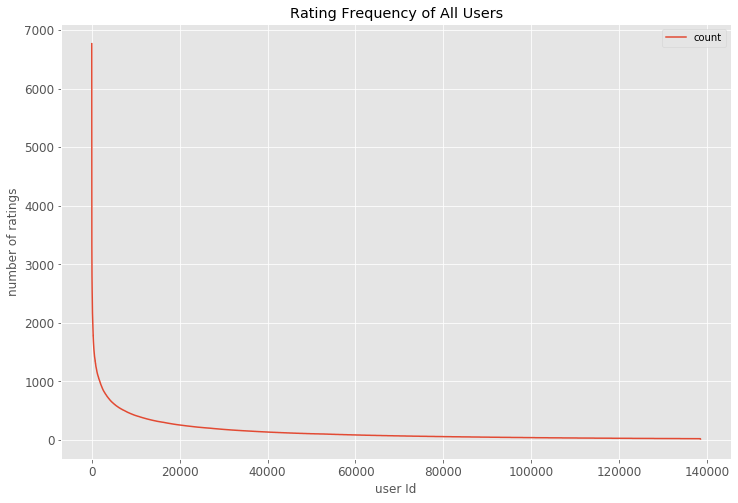

In [26]:
# plot rating frequency of all movies
ax = df_users_cnt \
    .sort_values('count', ascending=False) \
    .reset_index(drop=True) \
    .plot(
        figsize=(12, 8),
        title='Rating Frequency of All Users',
        fontsize=12
    )
ax.set_xlabel("user Id")
ax.set_ylabel("number of ratings")

In [27]:
df_users_cnt['count'].quantile(np.arange(1, 0.5, -0.05))

1.00    6769.0
0.95     518.0
0.90     333.0
0.85     246.0
0.80     192.0
0.75     154.0
0.70     127.0
0.65     107.0
0.60      92.0
0.55      78.0
Name: count, dtype: float64

We can see that the distribution of ratings by users is very similar to the distribution of ratings among movies. They both have long-tail property. Only a very small fraction of users are very actively engaged with rating movies that they watched. Vast majority of users aren't interested in rating movies. So we can limit users to the top 40%, which is about 113,291 users.

In [28]:
# filter data
ratings_thres = 50
active_users = list(set(df_users_cnt.query('count >= @ratings_thres').index))
df_ratings_drop_users = df_ratings_drop_movies[df_ratings_drop_movies.userId.isin(active_users)]
print('shape of original ratings data: ', df_ratings.shape)
print('shape of ratings data after dropping both unpopular movies and inactive users: ', df_ratings_drop_users.shape)

shape of original ratings data:  (20000263, 3)
shape of ratings data after dropping both unpopular movies and inactive users:  (18181935, 3)


## 3. Train KNN model for item-based collaborative filtering
 - Reshaping the Data
 - Fitting the Model

#### 1. Reshaping the Data
For K-Nearest Neighbors, we want the data to be in an (artist, user) array, where each row is a movie and each column is a different user. To reshape the dataframe, we'll pivot the dataframe to the wide format with movies as rows and users as columns. Then we'll fill the missing observations with 0s since we're going to be performing linear algebra operations (calculating distances between vectors). Finally, we transform the values of the dataframe into a scipy sparse matrix for more efficient calculations.

In [29]:
# pivot and create movie-user matrix
movie_user_mat = df_ratings_drop_users.pivot(index='movieId', columns='userId', values='rating').fillna(0)
# create mapper from movie title to index
movie_to_idx = {
    movie: i for i, movie in 
    enumerate(list(df_movies.set_index('movieId').loc[movie_user_mat.index].title))
}
# transform matrix to scipy sparse matrix
movie_user_mat_sparse = csr_matrix(movie_user_mat.values)

#### 2. Fitting the Model
Time to implement the model. We'll initialize the NearestNeighbors class as model_knn and fit our sparse matrix to the instance. By specifying the metric = cosine, the model will measure similarity bectween artist vectors by using cosine similarity.

In [30]:
%env JOBLIB_TEMP_FOLDER=/tmp
# define model
model_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)
# fit
model_knn.fit(movie_user_mat_sparse)

env: JOBLIB_TEMP_FOLDER=/tmp


NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=-1, n_neighbors=20, p=2,
                 radius=1.0)

## 4. Use this trained model to make movie recommendations to myself
And we're finally ready to make some recommendations!

In [31]:
def fuzzy_matching(mapper, fav_movie, verbose=True):
    """
    return the closest match via fuzzy ratio. If no match found, return None
    
    Parameters
    ----------    
    mapper: dict, map movie title name to index of the movie in data

    fav_movie: str, name of user input movie
    
    verbose: bool, print log if True

    Return
    ------
    index of the closest match
    """
    match_tuple = []
    # get match
    for title, idx in mapper.items():
        ratio = fuzz.ratio(title.lower(), fav_movie.lower())
        if ratio >= 60:
            match_tuple.append((title, idx, ratio))
    # sort
    match_tuple = sorted(match_tuple, key=lambda x: x[2])[::-1]
    if not match_tuple:
        print('Oops! No match is found')
        return
    if verbose:
        print('Found possible matches in our database: {0}\n'.format([x[0] for x in match_tuple]))
    return match_tuple[0][1]



def make_recommendation(model_knn, data, mapper, fav_movie, n_recommendations):
    """
    return top n similar movie recommendations based on user's input movie


    Parameters
    ----------
    model_knn: sklearn model, knn model

    data: movie-user matrix

    mapper: dict, map movie title name to index of the movie in data

    fav_movie: str, name of user input movie

    n_recommendations: int, top n recommendations

    Return
    ------
    list of top n similar movie recommendations
    """
    # fit
    model_knn.fit(data)
    # get input movie index
    print('You have input movie:', fav_movie)
    idx = fuzzy_matching(mapper, fav_movie, verbose=True)
    # inference
    print('Recommendation system start to make inference')
    print('......\n')
    distances, indices = model_knn.kneighbors(data[idx], n_neighbors=n_recommendations+1)
    # get list of raw idx of recommendations
    raw_recommends = \
        sorted(list(zip(indices.squeeze().tolist(), distances.squeeze().tolist())), key=lambda x: x[1])[:0:-1]
    # get reverse mapper
    reverse_mapper = {v: k for k, v in mapper.items()}
    # print recommendations
    print('Recommendations for {}:'.format(fav_movie))
    for i, (idx, dist) in enumerate(raw_recommends):
        print('{0}: {1}, with distance of {2}'.format(i+1, reverse_mapper[idx], dist))

In [32]:
my_favorite = 'Iron Man'

make_recommendation(
    model_knn=model_knn,
    data=movie_user_mat_sparse,
    fav_movie=my_favorite,
    mapper=movie_to_idx,
    n_recommendations=10)

You have input movie: Iron Man
Found possible matches in our database: ['Iron Man (2008)', 'Iron Man 3 (2013)', 'Iron Man 2 (2010)']

Recommendation system start to make inference
......

Recommendations for Iron Man:
1: V for Vendetta (2006), with distance of 0.4533616900444031
2: 300 (2007), with distance of 0.45118069648742676
3: Iron Man 2 (2010), with distance of 0.4416479468345642
4: Casino Royale (2006), with distance of 0.4318864345550537
5: Avatar (2009), with distance of 0.4282780885696411
6: Bourne Ultimatum, The (2007), with distance of 0.4220768213272095
7: Batman Begins (2005), with distance of 0.4157335162162781
8: WALL·E (2008), with distance of 0.3947794437408447
9: Star Trek (2009), with distance of 0.3870503902435303
10: Dark Knight, The (2008), with distance of 0.3106953501701355


This is very interesting that my **KNN** model recommends movies that were also produced in very similar years. However, the cosine distance of all those recommendations are actually quite small. This is probabily because there is too many zero values in our movie-user matrix. With too many zero values in our data, the data sparsity becomes a real issue for **KNN** model and the distance in **KNN** model starts to fall apart. So I'd like to dig deeper and look closer inside our data.

#### (extra inspection) 
Let's now look at how sparse the movie-user matrix is by calculating percentage of zero values in the data.

In [33]:
# calcuate total number of entries in the movie-user matrix
num_entries = movie_user_mat.shape[0] * movie_user_mat.shape[1]
# calculate total number of entries with zero values
num_zeros = (movie_user_mat==0).sum(axis=1).sum()
# calculate ratio of number of zeros to number of entries
ratio_zeros = num_zeros / num_entries
print('There is about {:.2%} of ratings in our data is missing'.format(ratio_zeros))

There is about 97.97% of ratings in our data is missing


This result confirms my hypothesis. The vast majority of entries in our data is zero. This explains why the distance between similar items or opposite items are both pretty large.

## 5. Deep dive into the bottleneck of item-based collaborative filtering.
 - cold start problem
 - data sparsity problem
 - popular bias (how to recommend products from the tail of product distribution)
 - scalability bottleneck

We saw there is 98.35% of user-movie interactions are not yet recorded, even after I filtered out less-known movies and inactive users. Apparently, we don't even have sufficient information for the system to make reliable inferences for users or items. This is called **Cold Start** problem in recommender system.

There are three cases of cold start:

1. New community: refers to the start-up of the recommender, when, although a catalogue of items might exist, almost no users are present and the lack of user interaction makes very hard to provide reliable recommendations
2. New item: a new item is added to the system, it might have some content information but no interactions are present
3. New user: a new user registers and has not provided any interaction yet, therefore it is not possible to provide personalized recommendations

We are not concerned with the last one because we can use item-based filtering to make recommendations for new user. In our case, we are more concerned with the first two cases, especially the second case.

The item cold-start problem refers to when items added to the catalogue have either none or very little interactions. This constitutes a problem mainly for collaborative filtering algorithms due to the fact that they rely on the item's interactions to make recommendations. If no interactions are available then a pure collaborative algorithm cannot recommend the item. In case only a few interactions are available, although a collaborative algorithm will be able to recommend it, the quality of those recommendations will be poor. This arises another issue, which is not anymore related to new items, but rather to unpopular items. In some cases (e.g. movie recommendations) it might happen that a handful of items receive an extremely high number of iteractions, while most of the items only receive a fraction of them. This is also referred to as popularity bias. Please recall previous long-tail skewed distribution of movie rating frequency plot.

In addtition to that, scalability is also a big issue in KNN model too. Its time complexity is O(nd + kn), where n is the cardinality of the training set and d the dimension of each sample. And KNN takes more time in making inference than training, which increase the prediction latency

## 6. Further study

Use spark's ALS to solve above problems